# Imports

In [1]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

In [2]:
import os
import logging
import sys
import inspect
from copy import copy

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import itertools
import pandas as pd
import random
import optuna
from optuna.trial import TrialState
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.distributions as dist
import torch.optim as optim
from torch.optim import Adam, RMSprop
import torch.utils.data
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import utils.models as m
import utils.acg_models as m2
from torchvision import transforms
from sklearn.model_selection import LeaveOneOut
import npyx

import utils.h5_utils as h5
from utils.constants import DATA_PATH, N_CHANNELS, CENTRAL_RANGE, BATCH_SIZE, LABELLING, CORRESPONDENCE, ACG_LEN
from pathlib import Path
from npyx.feat import temporal_features
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

npyx version 2.5.2 imported.


/home/npyx/miniconda3/envs/npyx/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
PATH = os.path.dirname(os.path.abspath(""))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CLASSES = 6
DIR = os.getcwd()
BASE_DATASET = h5.NeuronsDataset(DATA_PATH, quality_check=True, normalise=False)
BASE_DATASET.min_max_scale()
BASE_DATASET.make_full_dataset(wf_only=True)
LABELS_ONLY_DATASET = copy(BASE_DATASET)
LABELS_ONLY_DATASET.make_labels_only()
SEED = 1234
USE_CUDA = torch.cuda.is_available()
TEST_FREQUENCY = 1
BETA = 1

INIT_WEIGHTS = True

h5.set_seed(SEED)
torch.set_default_dtype(torch.float32)

Reading dataset:   0%|          | 0/1213 [00:00<?, ?it/s]

954 neurons loaded, of which labelled: 77 
259 neurons discarded, of which labelled: 7. More details at the 'discarded_df' attribute.
Random seed 1234 has been set.


In [4]:
labels = BASE_DATASET.targets
wf_dataset = BASE_DATASET.wf
acg_dataset = BASE_DATASET.acg
spikes = BASE_DATASET.spikes_list

In [5]:
class CerebellumWFDataset(data.Dataset):
    """Dataset of waveforms as images. Every batch will have shape:
    (batch_size, 1, N_CHANNELS, CENTRAL_RANGE)"""

    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (ndarray): Array of data points
            labels (string): Array of labels for the provided data
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        data_point = (
            self.data[idx, :].astype("float32").reshape(1, N_CHANNELS, CENTRAL_RANGE)
        )
        label = self.labels[idx].astype("int")

        sample = (data_point, label)

        if self.transform:
            sample = self.transform(sample)

        return sample


class CerebellumACGDataset(data.Dataset):

    """Dataset of ACGS. Every batch will have shape:
    (batch_size, 1, ACG_LEN)"""

    def __init__(self, data, labels, spikes, transform=None):
        """
        Args:
            data (ndarray): Array of data points, with wvf and acg concatenated
            labels (string): Array of labels for the provided data
        """
        self.data = data
        self.labels = labels
        self.transform = transform
        self.spikes = spikes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        data_point = self.data[idx, :].astype("float32").reshape(1, -1)
        label = self.labels[idx].astype("int")
        spikes = self.spikes[idx].astype("int")
        sample = (data_point, label)

        if self.transform:
            sample, spikes = self.transform(sample, spikes)

        return sample


In [6]:
# Add augmentation transforms if wanted
composed_wvf = transforms.Compose([m.VerticalReflection(p=0.3), m.SwapChannels(p=0.5)])
composed_acg = m2.CustomCompose(
    [
        m2.ConstantShift(p=0.1),
        m2.DeleteSpikes(p=0.01),
        m2.AddSpikes(p=0.01),
        m2.MoveSpikes(p=0.1),
    ]
)


cerebellum_wvf_dataset = CerebellumWFDataset(wf_dataset, labels, transform=composed_wvf)
train_loader_wvf = data.DataLoader(
    cerebellum_wvf_dataset, batch_size=BATCH_SIZE, shuffle=True
)

cerebellum_acg_dataset = CerebellumACGDataset(
    acg_dataset, labels, spikes, transform=composed_acg
)
train_loader_acg = data.DataLoader(
    cerebellum_acg_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [7]:
class Encoder(nn.Module):
    def __init__(self, encoder, d_latent):
        super().__init__()
        self.encoder = encoder.float()
        self.d_latent = d_latent

    def forward(self, x):
        # flatten the image
        x = x.view(x.shape[0], -1)
        # forward pass through encoder network
        h = self.encoder(x)
        # split the output into mu and log_var
        mu = h[:, : self.d_latent]
        log_var = h[:, self.d_latent :]
        # return mu and log_var
        return dist.Normal(mu, torch.exp(log_var))

class acg_Decoder(nn.Module):
    def __init__(self, decoder, d_latent):
        super().__init__()
        self.decoder = decoder.float()
        self.d_latent = d_latent

    def forward(self, z):
        # flatten the latent vector
        z = z.view(z.shape[0], -1)
        # forward pass through decoder network
        h = self.decoder(z)

        X_hat = h[:, :ACG_LEN]
        log_sig = h[:, ACG_LEN:]

        return dist.Normal(
            X_hat.reshape(-1, 1, ACG_LEN),
            log_sig.reshape(-1, 1, ACG_LEN).exp(),
        )
def ELBO_VAE(enc, dec, X, beta=1):
    """

    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 10, 60).

    """

    batch_size = X.shape[0]
    n_samples = 20  # number of monte carlo samples
    prior = dist.MultivariateNormal(
        loc=torch.zeros(enc.d_latent).to(DEVICE),
        covariance_matrix=torch.eye(enc.d_latent).to(DEVICE),
    )
    ELBO = torch.zeros(batch_size).to(DEVICE)

    for _ in range(n_samples):

        q_z = enc.forward(X)  # q(Z | X)
        z = (
            q_z.rsample()
        )  # Samples from the encoder posterior q(Z | X) using the reparameterization trick
        p_x = dec.forward(z)  # distribution p(x | z)

        log_prior = prior.log_prob(z)  # log( p(z_i) )
        dec_log_likelihood = (
            p_x.log_prob(X).reshape(batch_size, -1).sum(axis=1)
        )  # log( p(x_i | z_i) )
        enc_posterior = q_z.log_prob(z).sum(axis=1)  # log( q(z_i | x_i) )

        # Calculate the ELBO on the whole batch
        ELBO += dec_log_likelihood + beta * (-enc_posterior + log_prior)

    return ELBO / n_samples

In [8]:
def define_acg_model(params=None):
    if params is None:
        best_params = optuna.load_study(
            "double-VAE_v2", f"sqlite:///{PATH}/double-VAE_v2.db"
        ).best_params
    else:
        best_params = params

    n_layers = best_params["acg_n_layers"]
    d_latent = best_params["acg_d_latent"]

    in_features = ACG_LEN

    encoder_layers = []
    decoder_layers = []
    first_units = None

    for i in range(n_layers):
        out_features = best_params[f"acg_n_units_l{i}"]
        p = best_params[f"acg_dropout_l{i}"]
        if i == 0:
            first_units = out_features

        # Create and properly init encoder layer
        cur_enc_layer = nn.Linear(in_features, out_features)
        if INIT_WEIGHTS:
            cur_enc_layer.weight.data.normal_(0, 0.001)
            cur_enc_layer.bias.data.normal_(0, 0.001)

        # Create and properly init decoder layer
        cur_dec_layer = nn.Linear(out_features, in_features)
        if INIT_WEIGHTS:
            cur_dec_layer.weight.data.normal_(0, 0.001)
            cur_dec_layer.bias.data.normal_(0, 0.001)

        encoder_layers.append(cur_enc_layer)
        decoder_layers.append(cur_dec_layer)

        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Dropout(p))

        encoder_layers.append(nn.Dropout(p))
        decoder_layers.append(nn.ReLU())

        in_features = out_features
    encoder_layers.append(nn.Linear(in_features, d_latent))
    decoder_layers.append(nn.Linear(d_latent, in_features))

    encoder = nn.Sequential(*encoder_layers[:-1], nn.Linear(in_features, 2 * d_latent))
    decoder = nn.Sequential(
        *decoder_layers[:0:-1], nn.Linear(first_units, 2 * (ACG_LEN))
    )

    encoder = Encoder(encoder, d_latent)
    decoder = acg_Decoder(decoder, d_latent)

    return encoder.to(DEVICE), decoder.to(DEVICE)

# Loading or training the encoder

In [9]:
# get relative data folder
PATH = os.path.dirname(os.path.abspath(''))
data_folder = PATH + '/data'
DATA_PATH = data_folder + ("/Aug-09-2022_all_features.csv")
df = pd.read_csv(DATA_PATH, index_col=0)

In [10]:
def generate_train_and_labels(df: pd.DataFrame, info_idx = [0, 1 , 2 ,18]):
    info = df.iloc[:, info_idx]
    features = df.iloc[:, ~np.isin(np.arange(len(df.columns)), info_idx)]
    return features.copy(), info.iloc[:, 0].copy()

def filter_df(df:pd.DataFrame):
    """
    Filters out datapoints with unusable temporal features.
    """
    features_only = df.iloc[:, 2:]
    bad_idx = []
    for i, row in features_only.iterrows():
        value, count = np.unique(row.to_numpy(), return_counts=True)
        zeros = count[value == 0]
        if  zeros.size > 0 and zeros > 5:
            bad_idx.append(i)
    keep = [i for i in range(len(df)) if i not in bad_idx]
    return df.iloc[keep]

In [11]:
df = filter_df(df)

In [12]:
best_params = optuna.load_study(
            "double-VAE_v2", f"sqlite:///{PATH}/double-VAE_v2.db"
        ).best_params


acg_enc, acg_dec = define_acg_model()

acg_enc.load_state_dict(torch.load(f"{PATH}/best_acg_enc_v2.pt", map_location=DEVICE))
acg_dec.load_state_dict(torch.load(f"{PATH}/best_acg_dec_v2.pt", map_location=DEVICE))

acg_enc.eval()
acg_dec.eval()

tmp_features = []
for acg in tqdm(LABELS_ONLY_DATASET.acg):
    acg_tensor = (
        torch.tensor(acg, dtype=torch.float32).to(DEVICE).reshape(1, 1, ACG_LEN)
    )
    with torch.no_grad():
        enc_features = acg_enc(acg_tensor).mean.detach().cpu().numpy().ravel()
    tmp_features.append(enc_features)

wvf_features = []
for info in tqdm(LABELS_ONLY_DATASET.info):
    split_string = info.split("/")
    dp = "/".join(split_string[:-1])
    unit = int(split_string[-1])
    where_mask = unit == df["unit"].to_numpy()
    df_unit = df.loc[where_mask]
    enc_features, y = generate_train_and_labels(df_unit)
    wvf_features.append(enc_features.squeeze()[16:])
    

wf_dataset = np.stack(wvf_features, axis=0).squeeze()
tmp_dataset = np.stack(tmp_features, axis=0)

X = np.concatenate((wf_dataset, tmp_dataset), axis=1)
nan_mask = np.isnan(X).any(axis=1)
X = X[~nan_mask]
y = LABELS_ONLY_DATASET.targets[~nan_mask]


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [13]:
N_LOOS = 50

In [14]:
forest_params = optuna.load_study(
    "random-forest-feat-eng", f"sqlite:///{PATH}/random-forest-feat-eng.db"
).best_params
h5.set_seed(SEED)


f1_scores = []
confusions_list = []

for loo in tqdm(range(N_LOOS), position = 0, leave = True, desc = "Random Forest runs"):
    
    kfold = LeaveOneOut()
    train_accuracies = []
    true_targets = []
    model_pred = []
    dummy_pred = []
    seed = np.random.choice(2**32)
    for fold, (train_idx, val_idx) in tqdm(
        enumerate(kfold.split(X, y)),
        leave=False,
        position=1,
        desc="Cross-validating",
        total=len(X),
    ):

        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[val_idx]
        y_test = y[val_idx]

        oversample = RandomOverSampler(random_state=seed)

        X_big, y_big = oversample.fit_resample(X_train, y_train)

        model = RandomForestClassifier(**forest_params, random_state=seed)

        # fit the model on the data
        model.fit(X_big, y_big)
        pred = model.predict(X_test)
        train_accuracies.append(model.score(X_train, y_train))

        true_targets.append(y_test)
        model_pred.append(pred)
        

        ####### Now doing something similar with a Dummy Classifier so that we can plot a baseline #########
        dummy = DummyClassifier(strategy="uniform")
        # fit the model on the data
        dummy.fit(X_big, y_big)
        pred = dummy.predict(X_test)

        dummy_pred.append(pred)
        
    confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, 6))
    confusions_list.append(confusion)
    f1 = f1_score(true_targets, model_pred, average='macro')
    f1_scores.append(f1)



mean_train = np.array(train_accuracies).mean()
mean_validation = (np.array(true_targets)==np.array(model_pred)).mean()
mean_dummy = (np.array(true_targets)==np.array(dummy_pred)).mean()
print(
f"Mean train accuracy is {mean_train:.3f} while LOO accuracy is {mean_validation:.3f}"
)
print(f"Dummy LOO accuracy is {mean_dummy:.3f} ")
print(f"Mean LOO f1 score across random forests is {np.array(f1_scores).mean():.3f}")


Random seed 1234 has been set.


Random Forest runs:   0%|          | 0/50 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Mean train accuracy is 0.982 while LOO accuracy is 0.727
Dummy LOO accuracy is 0.208 
Mean LOO f1 score across random forests is 0.582


In [15]:
np.std(np.array(f1_scores))

0.026408552987092323

In [21]:
np.array(train_accuracies).std()

0.006222536382786407

In [16]:
max(f1_scores)

0.6456189805027014

In [22]:
X.shape

(77, 30)

# Confusion matrix

In [17]:
mean_confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, 6))
mean_confusion = mean_confusion / (np.sum(mean_confusion, axis = 0)) * 100 # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

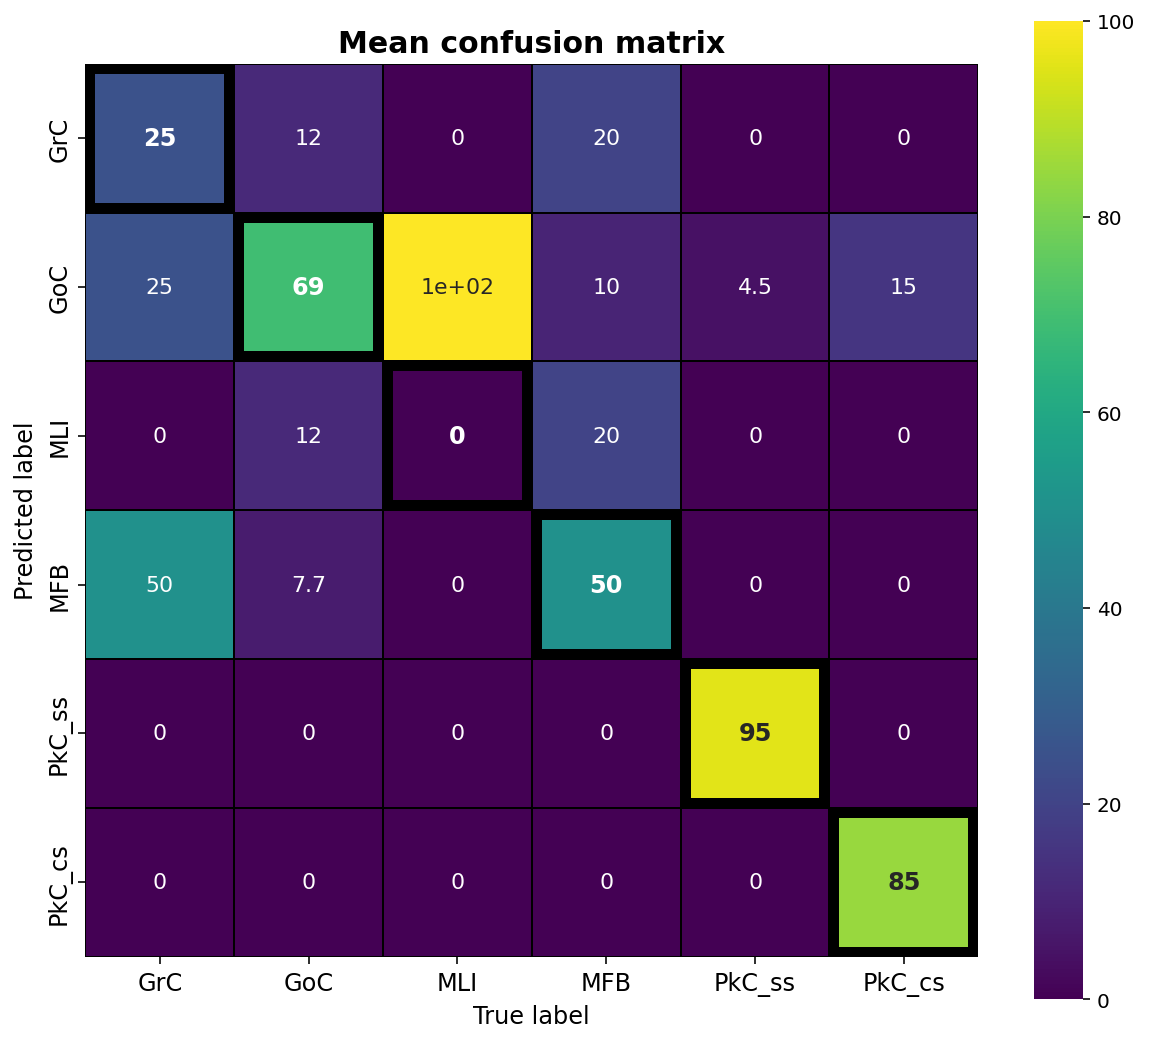

In [18]:
# Confusion matrix
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # necessary to make the text editable
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    cbar=False,
    mask=mask,
    linewidths=10,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    square=True,
    vmin=0,
    vmax=100,
    mask=~mask,
    linewidths=1,
    linecolor="black",
    annot_kws={"fontsize": 11},
)
x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12);


# Latent space visualisation

In [19]:
def plot_random_reconstruction(full_dataset, enc, dec, network_inputs, dataset_info, n_neurons=1, label=None):
    """
    Plots a random neuron from the dataset. Optionally, can specify a label
    """
    if label is not None:
        if label in CORRESPONDENCE:
            mask = full_dataset[:, 0] == label
            full_dataset = full_dataset[mask, :]
            network_inputs = network_inputs[mask, :]
        elif label in LABELLING:
            mask = full_dataset[:, 0] == LABELLING[label]
            full_dataset = full_dataset[mask, :]
            network_inputs = network_inputs[mask, :]
        else:
            return "Invalid label"

    if n_neurons > full_dataset.shape[0]:
        print(
            f"Only {full_dataset.shape[0]} neurons to plot with the provided parameter choice"
        )
        n_neurons = full_dataset.shape[0]

    idx = np.random.choice(range(full_dataset.shape[0]), n_neurons, replace=False)
    for i in idx:
        fig, axs = plt.subplots(1, 4, figsize=(14, 3), constrained_layout=True)
        fig.suptitle(
            r"$\bf{"
            + CORRESPONDENCE[full_dataset[i, 0]]
            + "}$ - "
            + "Dataset: "
            + dataset_info[i]
        )
        wf_original = full_dataset[i, 1 : N_CHANNELS * CENTRAL_RANGE + 1].reshape(
            N_CHANNELS, CENTRAL_RANGE
        )
        acg_original = full_dataset[i, N_CHANNELS * CENTRAL_RANGE + 1 :]


        n_lines = wf_original.shape[0]
        x = range(wf_original.shape[1])
        linewidth = 4
        for j, row in enumerate(wf_original):
            if j == 5:
                line = row + (n_lines - j)
                axs[0].plot(
                    x, line, lw=linewidth, c="red", alpha=1, zorder=j / n_lines
                )
            # elif i % 2 == 0:
            #     continue
            else:
                line = row + (n_lines - j)
                axs[0].plot(
                    x, line, lw=linewidth, c="grey", alpha=1, zorder=j / n_lines
                )
        axs[0].set_title("Original Raw waveforms")
        axs[0].set_yticks([])

        axs[1].plot(wf_original[N_CHANNELS // 2, :])
        axs[1].set_title("Original Peak channel waveform")

        axs[2].plot(np.concatenate((acg_original[::-1], acg_original)))
        axs[2].set_title("Original autocorrelogram")
        
        # Getting this y scale for later:
        y_min, y_max = axs[2].get_ylim()

        with torch.no_grad():
            network_input = torch.Tensor(
                network_inputs[i].reshape(1, 1, -1).astype(np.float32)
            )
            reconstructed_acg = (
                dec(enc(network_input).sample()).mean.detach().numpy().ravel()
            )
            acg_reconstructed_stddev = (
                dec(enc(network_input).sample()).stddev.detach().numpy().ravel()
            )

        full_reconstructed_acg = np.concatenate((reconstructed_acg[::-1], reconstructed_acg))
        full_reconstructed_acg_stdev = np.concatenate((acg_reconstructed_stddev[::-1], acg_reconstructed_stddev))
        axs[3].plot(full_reconstructed_acg)
        axs[3].set_title("Reconstructed autocorrelogram")
        axs[3].fill_between(
            range(full_reconstructed_acg.shape[0]),
            full_reconstructed_acg + full_reconstructed_acg_stdev,
            full_reconstructed_acg - full_reconstructed_acg_stdev,
            alpha=0.2
        )
        axs[3].set_ylim(y_min, y_max)

        plt.show()

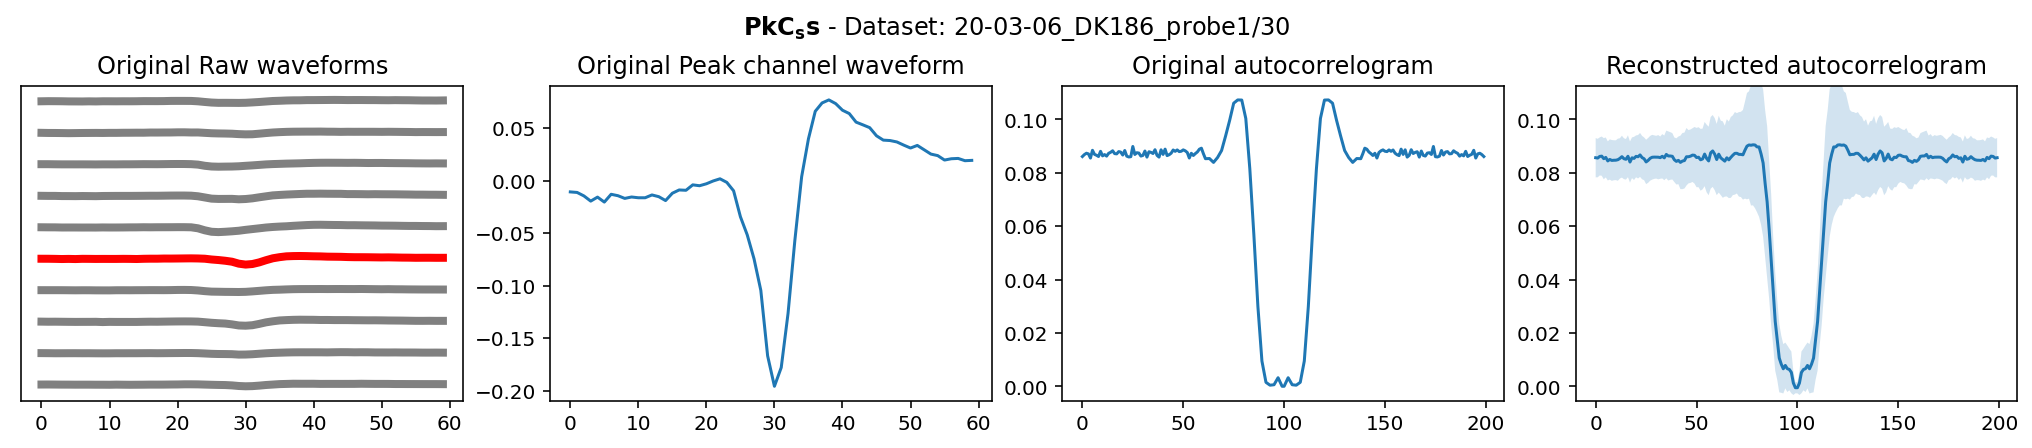

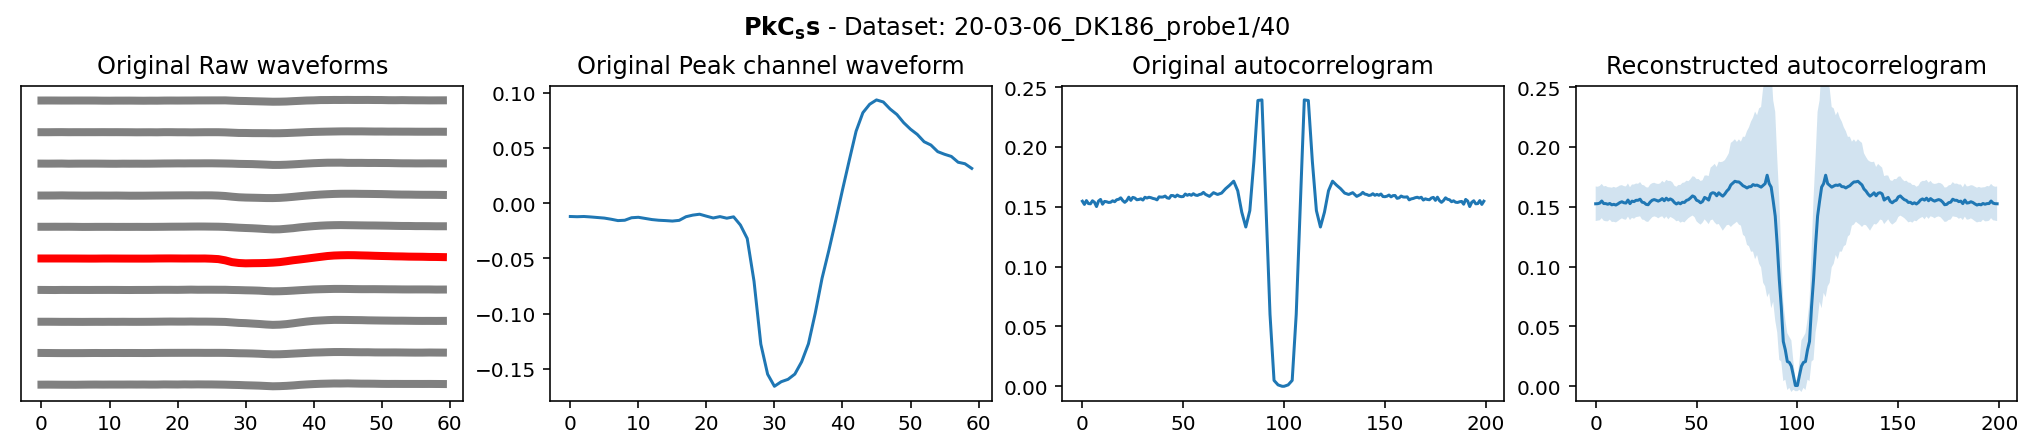

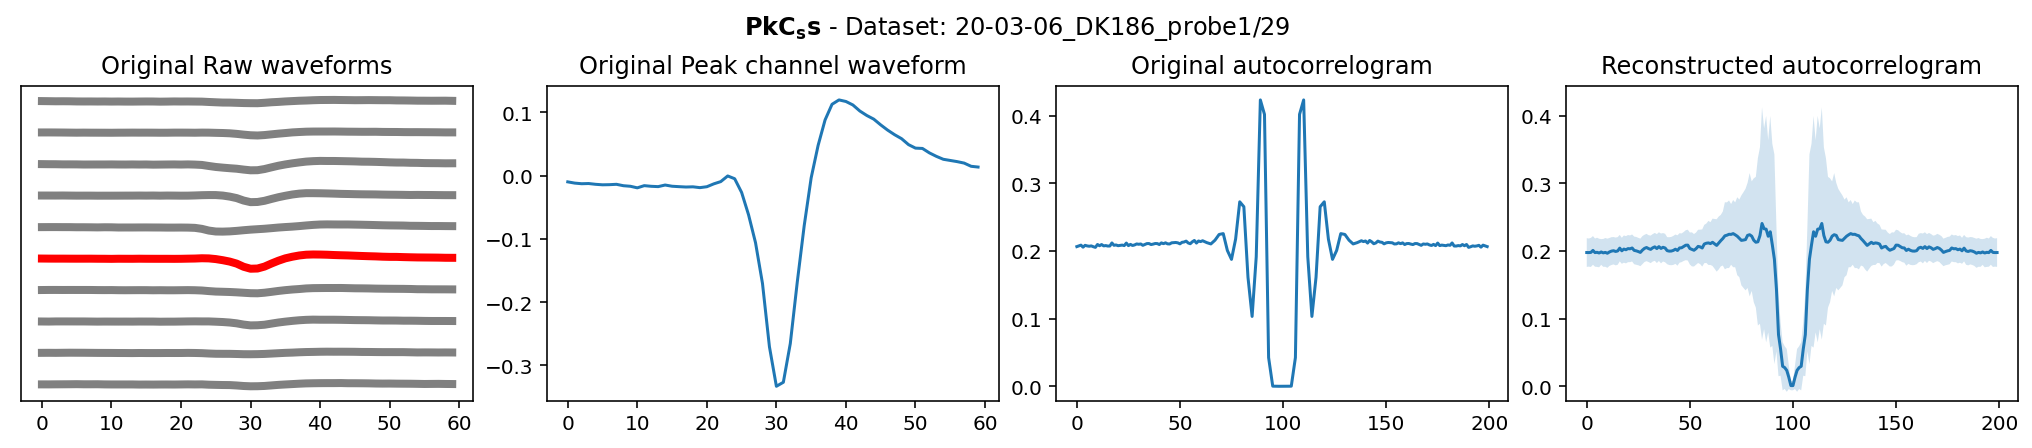

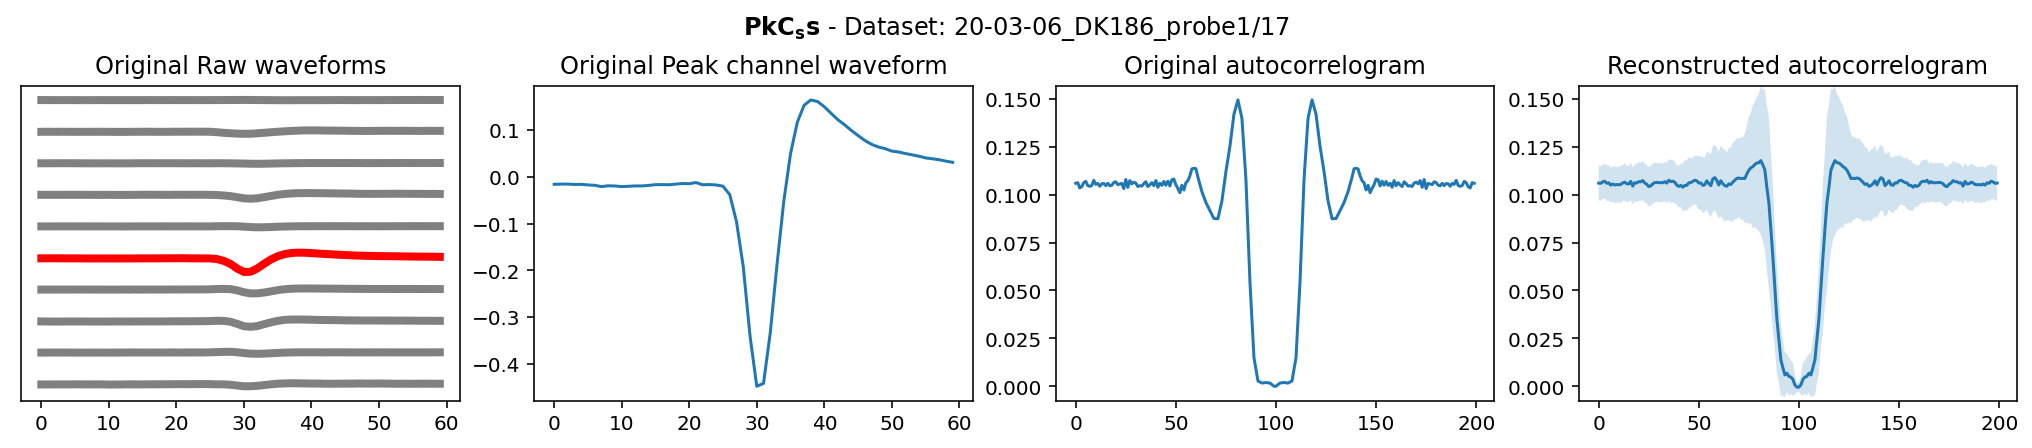

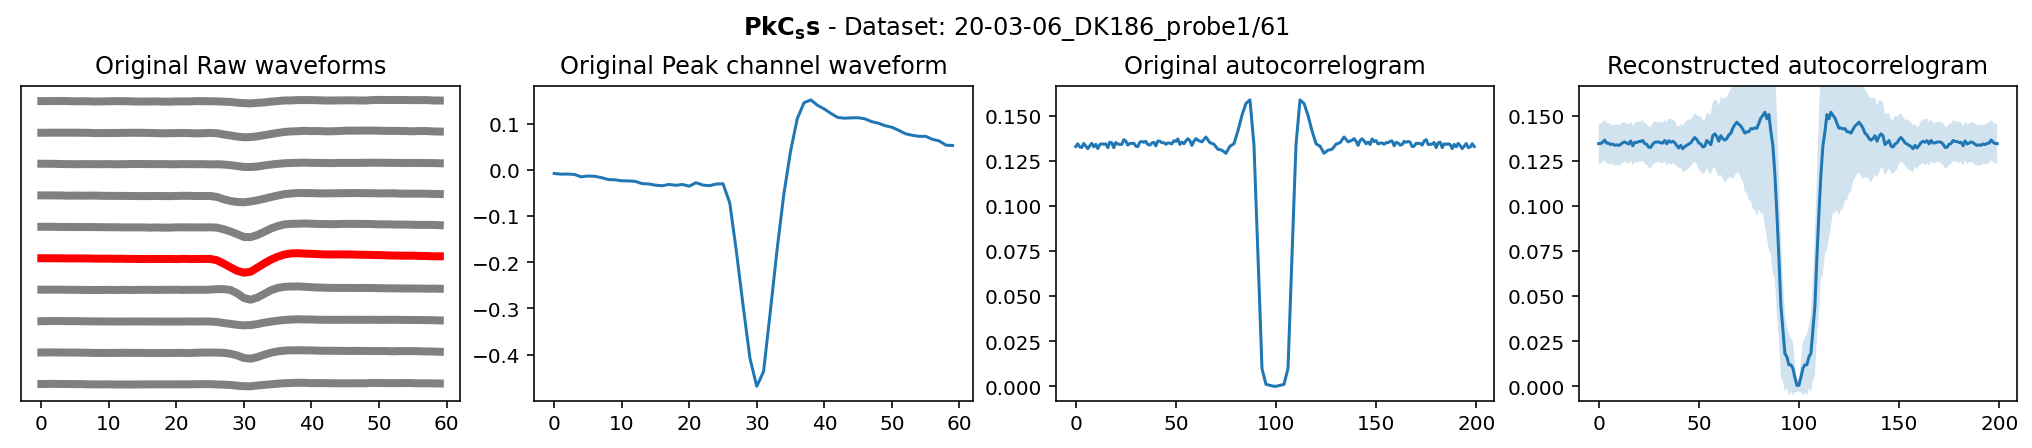

In [34]:
full_plotting_dataset = np.concatenate((BASE_DATASET.targets[:, None], BASE_DATASET.wf, BASE_DATASET.acg), axis=1)
dataset_info = BASE_DATASET.info
plot_random_reconstruction(full_plotting_dataset, acg_enc.cpu(), acg_dec.cpu(), BASE_DATASET.acg, dataset_info, n_neurons=5, label="PkC_ss")

In [26]:
plotting_dataset = CerebellumACGDataset(LABELS_ONLY_DATASET.acg, LABELS_ONLY_DATASET.targets, LABELS_ONLY_DATASET.spikes_list)
plotting_train_loader = data.DataLoader(plotting_dataset, batch_size=len(plotting_dataset))
X_random_batch, y_random_batch = next(iter(plotting_train_loader))

In [28]:
enc, dec = acg_enc.cpu(), acg_dec.cpu()

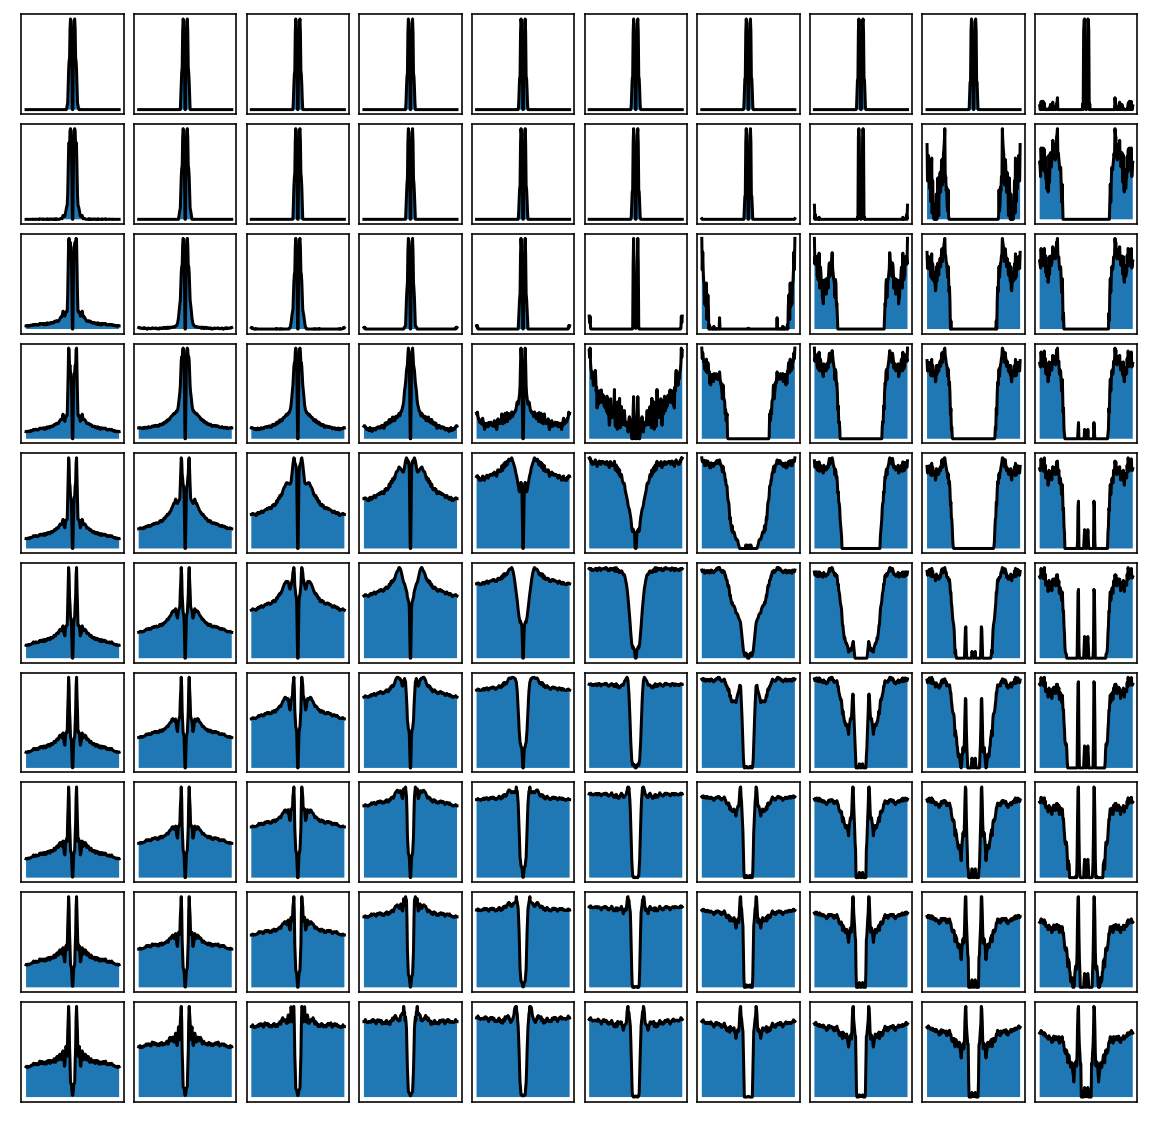

In [55]:
def plot_2d_latent(encoder, decoder, random_batch, n = 20, save=False, std=1):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    # Take the first 2 right singular vectors from the SVD of the mean latent space vector over a random batch
    W = torch.linalg.svd(encoder(random_batch).mean).Vh[:2]
    # Take the inverse cdf of n evenly spaced points from 0 to 1
    points = dist.Normal(0, std).icdf(torch.linspace(0.01, 0.99, n))
    # Create a nxn meshgrid with the points
    XX, YY = torch.meshgrid(points, points)
    # Stack the meshgrid, then reshape to 2 x xxyy. Then transpose so final is xxyy x 2
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    # Get the decoder output of W transformed by that matrix. W is 2 x batch_size
    with torch.no_grad():
        out = decoder(XXYY @ W).mean.numpy().squeeze()
    
    fig = plt.figure(figsize=(min((n, 15)), min((n, 15))))
    gs = fig.add_gridspec(ncols=n, nrows=n, hspace=0.1, wspace=0.1)
    axs = gs.subplots()
    count = 0
    for i in range(n):
        for j in range(n):
            half_acg = out[count, :]
            full_acg = np.concatenate((half_acg[::-1], half_acg))
            full_acg = np.clip(full_acg,0,None)
            axs[i, j].plot(full_acg, color='black')
            axs[i, j].fill_between(np.arange(0, len(full_acg)), full_acg)
            axs[i,j].set_yticks([])
            axs[i,j].set_xticks([])
            axs[i,j].label_outer()
            count += 1
    
    if save:
        plt.savefig(f"acg_latent_space_{n}.pdf")
    plt.show()
    

plot_2d_latent(enc, dec, X_random_batch, n=10, save=True, std=2)